*Test of applying PCA to a set of spike data from AllenSDK*

## Loading in the AllenSDK modules

In [1]:
# first we need a bit of import boilerplate
import os

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import scipy

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import (
    EcephysSession, 
    removed_unused_stimulus_presentation_columns
)
from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot
from allensdk.brain_observatory.visualization import plot_running_speed

# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

***Here we give the path to the manifest file describing the experiments we're considering – sticking with one that we have loaded in previously but this can be changed***

In [2]:
manifest_path = os.path.join("quickstart_tut_files", "manifest.json")

cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [3]:
# data cache-level metadata
cache.get_session_table().head()

,published_at,specimen_id,session_type,age_in_days,sex,full_genotype,unit_count,channel_count,probe_count,ecephys_structure_acronyms
id,,,,,,,,,,
715093703,2019-10-03T00:00:00Z,699733581,brain_observatory_1.1,118.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,884,2219,6,"[CA1, VISrl, nan, PO, LP, LGd, CA3, DG, VISl, ..."
719161530,2019-10-03T00:00:00Z,703279284,brain_observatory_1.1,122.0,M,Sst-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,755,2214,6,"[TH, Eth, APN, POL, LP, DG, CA1, VISpm, nan, N..."
721123822,2019-10-03T00:00:00Z,707296982,brain_observatory_1.1,125.0,M,Pvalb-IRES-Cre/wt;Ai32(RCL-ChR2(H134R)_EYFP)/wt,444,2229,6,"[MB, SCig, PPT, NOT, DG, CA1, VISam, nan, LP, ..."
732592105,2019-10-03T00:00:00Z,717038288,brain_observatory_1.1,100.0,M,wt/wt,824,1847,5,"[grey, VISpm, nan, VISp, VISl, VISal, VISrl]"
737581020,2019-10-03T00:00:00Z,718643567,brain_observatory_1.1,108.0,M,wt/wt,568,2218,6,"[grey, VISmma, nan, VISpm, VISp, VISl, VISrl]"


***Selecting a session used in one of the earlier tutorials***

In [4]:
session_id = 715093703 # for example
session = cache.get_session_data(session_id)

In [5]:
session.invalid_times.head()

,start_time,stop_time,tags
id,,,
0,1830.70,1910.47,"[EcephysProbe, 810755801, probeC]"
1,3196.68,3281.44,"[EcephysProbe, 810755801, probeC]"
2,4500.09,4578.29,"[EcephysProbe, 810755801, probeC]"
3,5589.68,5661.90,"[EcephysProbe, 810755801, probeC]"
4,6627.92,6854.53,"[EcephysProbe, 810755801, probeC]"


In [6]:
# looking at a table of metadata for this session
session.units.head()

,snr,presence_ratio,waveform_spread,cumulative_drift,isolation_distance,waveform_amplitude,firing_rate,nn_hit_rate,isi_violations,waveform_velocity_below,L_ratio,nn_miss_rate,waveform_halfwidth,waveform_repolarization_slope,amplitude_cutoff,waveform_PT_ratio,silhouette_score,waveform_recovery_slope,waveform_duration,local_index_unit,max_drift,waveform_velocity_above,cluster_id,peak_channel_id,d_prime,c50_dg,area_rf,fano_dg,fano_fl,fano_ns,fano_rf,fano_sg,f1_f0_dg,g_dsi_dg,g_osi_dg,g_osi_sg,azimuth_rf,mod_idx_dg,p_value_rf,pref_sf_sg,pref_tf_dg,run_mod_dg,run_mod_fl,run_mod_ns,run_mod_rf,run_mod_sg,pref_ori_dg,pref_ori_sg,run_pval_dg,run_pval_fl,run_pval_ns,run_pval_rf,run_pval_sg,elevation_rf,pref_image_ns,pref_phase_sg,firing_rate_dg,firing_rate_fl,firing_rate_ns,firing_rate_rf,firing_rate_sg,on_off_ratio_fl,time_to_peak_ns,pref_sf_multi_sg,pref_tf_multi_dg,pref_ori_multi_dg,pref_ori_multi_sg,pref_phase_multi_sg,image_selectivity_ns,pref_image_multi_ns,lifetime_sparseness_dg,lifetime_sparseness_fl,lifetime_sparseness_ns,lifetime_sparseness_rf,lifetime_sparseness_sg,probe_vertical_position,probe_horizontal_position,probe_id,channel_local_index,ecephys_structure_id,ecephys_structure_acronym,anterior_posterior_ccf_coordinate,dorsal_ventral_ccf_coordinate,left_right_ccf_coordinate,probe_description,location,probe_sampling_rate,probe_lfp_sampling_rate,probe_has_lfp_data
unit_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
950910352,2.816993,0.99,60.0,419.57,69.455405,106.785900,4.532385,0.935531,0.029797,0.000000,0.002020,0.008277,0.096147,0.365539,0.057700,0.476196,0.080869,-0.153573,0.151089,6,34.38,-0.137353,6,850264156,4.576155,NaN,200.0,8.573516,NaN,3.563571,3.013333,3.472371,0.506292,0.121946,0.092779,0.109856,25.000,1.312811,0.479,0.32,4.0,0.987385,NaN,0.970335,1.000000,0.706667,180.0,120.0,0.000020,NaN,3.094523e-07,0.010614,3.288081e-03,50.000,4908,0.50,3.679539,0.0,5.399795,2.173257,4.740704,NaN,0.0185,False,False,False,False,False,0.074966,False,0.124258,NaN,0.053529,0.244172,0.055879,60,11,810755797,5,215.0,APN,8157.0,3521.0,6697.0,probeA,See electrode locations,29999.954846,1249.998119,True
950910364,2.592082,0.99,60.0,231.42,102.847616,85.808775,31.486161,0.995333,0.005998,0.343384,0.000146,0.002786,0.274707,0.147357,0.065649,0.953652,0.153496,-0.010004,0.480737,7,23.43,-0.618090,7,850264158,5.602703,NaN,800.0,0.696467,NaN,1.127965,1.382684,1.474619,0.553213,0.037434,0.029263,0.032803,51.250,2.509759,0.979,0.16,4.0,0.148090,NaN,-0.017989,0.172414,0.015326,225.0,120.0,0.001521,NaN,8.555631e-01,0.236355,9.013584e-01,-18.750,4951,0.50,26.488752,0.0,31.565193,27.097733,31.374439,NaN,0.1475,False,False,False,False,False,0.030797,False,0.013569,NaN,0.003357,0.024370,0.004924,80,59,810755797,6,215.0,APN,8154.0,3513.0,6698.0,probeA,See electrode locations,29999.954846,1249.998119,True
950910371,2.095077,0.99,70.0,209.31,76.907610,76.898055,17.328610,0.993333,0.005242,0.137353,0.004522,0.007975,0.164824,0.299231,0.015509,0.615593,0.089229,-0.071484,0.288442,8,57.44,0.274707,8,850264164,5.061817,NaN,300.0,6.767485,NaN,1.235328,3.876923,1.301639,0.223564,0.048717,0.050593,0.018864,86.667,1.024316,0.497,0.04,4.0,0.213891,NaN,0.204641,0.511111,-0.015873,225.0,30.0,0.329712,NaN,9.284294e-02,0.161964,9.037874e-01,46.667,4942,0.75,14.373947,0.0,17.881994,12.173311,19.064063,NaN,0.0435,False,False,False,False,False,0.005763,False,0.022789,NaN,0.005609,0.050257,0.005125,100,11,810755797,9,215.0,APN,8146.0,3487.0,6701.0,probeA,See electrode locations,29999.954846,1249.998119,True
950910392,3.024744,0.99,70.0,179.71,65.671206,120.519555,16.262414,0.944000,0.096884,-0.274707,0.007306,0.002874,0.109883,0.497249,0.025891,0.616317,0.139601,-0.116365,0.206030,11,33.65,0.000000,11,850264172,4.219074,NaN,100.0,14.891282,NaN,6.331037,4.973913,5.240884,0.286195,0.089741,0.038626,0.066273,10.000,0.915356,0.942,0.08,4.0,1.000000,NaN,0.937998,0.760504,0.791262,180.0,150.0,0.000002,NaN,2.323203e-11,0.000867

In [7]:
# we can use SNR to select just the least noisy channels for our analysis –
# not sure if this might have unintended consequence but seems like a reasonable thing to do

print(f'{session.units.shape[0]} units total')
# storing the units that we'll want to select
units_with_very_high_snr = session.units[session.units['snr'] > 4]
print(f'{units_with_very_high_snr.shape[0]} units have snr > 4')

# ... getting the indices of the high SNR units
high_snr_unit_ids = units_with_very_high_snr.index.values

884 units total
131 units have snr > 4


In [8]:
units_with_very_high_snr['probe_sampling_rate']

unit_id
950910603    29999.954846
950910651    29999.954846
950911040    29999.954846
950911088    29999.954846
950912928    29999.954846
                 ...     
950956259    30000.028033
950956527    30000.028033
950956778    30000.028033
950956870    30000.028033
950957053    30000.028033
Name: probe_sampling_rate, Length: 131, dtype: float64

***We can select the spike data from the high-SNR channels and also select a specific stimulus they're associated with. Here we'll select the first stimulus (and we'll arbitrarily choose 'drifting gradient' as the kind of stimulus we want):***

First have to select all the spike times associated with all the different drifting gradient stimuli...

In [9]:
# get spike times from the first block of drifting gratings presentations 
drifting_gratings_presentation_ids = session.stimulus_presentations.loc[
    (session.stimulus_presentations['stimulus_name'] == 'drifting_gratings')
].index.values

times = session.presentationwise_spike_times(
    stimulus_presentation_ids=drifting_gratings_presentation_ids,
    unit_ids=high_snr_unit_ids
)

times.head()

/opt/anaconda3/envs/allensdk/lib/python3.7/site-packages/allensdk/brain_observatory/ecephys/ecephys_session.py:1093: UserWarning: Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',Spikes within these intervals are invalid and may need to be excluded from the analysis.
  warnings.warn("Session includes invalid time intervals that could be accessed with the attribute 'invalid_times',"


,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
1574.776357,3798,950923011,0.001534
1574.776590,3798,950925626,0.001768
1574.776790,3798,950923880,0.001968
1574.777241,3798,950945986,0.002419
1574.777983,3798,950938657,0.003160


... then we'll choose the first specific stimulus occurence based on `stimulus_presentation_id`

In [10]:
# storing a list of the different stimulus presentation ids
# for the drifting gradients (just to easily check multiple different ones)
stim_pres_ids = times['stimulus_presentation_id'].unique()

### NB: there are 628 different presentations of the drifting gradient (thing to be considered if moving to training on multiple trials of a given stimulus from a given session)

In [11]:
len(stim_pres_ids)

628

***Checking the different numbers of recording channels in the different drifting gradient trials***

In [12]:
for pres_id in stim_pres_ids:
    print(times[times['stimulus_presentation_id'] == pres_id])

             stimulus_presentation_id    unit_id  \
spike_time                                         
1574.776357                      3798  950923011   
1574.776590                      3798  950925626   
1574.776790                      3798  950923880   
1574.777241                      3798  950945986   
1574.777983                      3798  950938657   
...                               ...        ...   
1576.773123                      3798  950938657   
1576.773956                      3798  950936025   
1576.773958                      3798  950925786   
1576.774872                      3798  950954905   
1576.776042                      3798  950948063   

             time_since_stimulus_presentation_onset  
spike_time                                           
1574.776357                                0.001534  
1574.776590                                0.001768  
1574.776790                                0.001968  
1574.777241                                0.002419  

             stimulus_presentation_id    unit_id  \
spike_time                                         
1670.855185                      3830  950954905   
1670.855746                      3830  950931727   
1670.856806                      3830  950919212   
1670.856821                      3830  950945986   
1670.856979                      3830  950924212   
...                               ...        ...   
1672.851288                      3830  950947211   
1672.851717                      3830  950936326   
1672.852914                      3830  950927341   
1672.854455                      3830  950949248   
1672.856522                      3830  950945077   

             time_since_stimulus_presentation_onset  
spike_time                                           
1670.855185                                0.000082  
1670.855746                                0.000643  
1670.856806                                0.001703  
1670.856821                                0.001718  

             stimulus_presentation_id    unit_id  \
spike_time                                         
1742.916422                      3854  950948210   
1742.919422                      3854  950946376   
1742.920787                      3854  950923669   
1742.920821                      3854  950922286   
1742.921487                      3854  950931458   
...                               ...        ...   
1744.906449                      3854  950955974   
1744.907838                      3854  950919212   
1744.909455                      3854  950930985   
1744.913889                      3854  950946376   
1744.915504                      3854  950939028   

             time_since_stimulus_presentation_onset  
spike_time                                           
1742.916422                                0.001089  
1742.919422                                0.004089  
1742.920787                                0.005454  
1742.920821                                0.005488  

             stimulus_presentation_id    unit_id  \
spike_time                                         
1869.022792                      3896  950913850   
1869.023834                      3896  950912396   
1869.025182                      3896  950946658   
1869.025759                      3896  950913877   
1869.027501                      3896  950910651   
...                               ...        ...   
1871.007670                      3896  950910651   
1871.010765                      3896  950913567   
1871.012565                      3896  950919212   
1871.016670                      3896  950910651   
1871.020004                      3896  950910651   

             time_since_stimulus_presentation_onset  
spike_time                                           
1869.022792                                0.002099  
1869.023834                                0.003141  
1869.025182                                0.004489  
1869.025759                                0.005066  

             stimulus_presentation_id    unit_id  \
spike_time                                         
2010.138900                      3943  950931727   
2010.139300                      3943  950922286   
2010.140234                      3943  950925332   
2010.140834                      3943  950923217   
2010.140867                      3943  950928686   
...                               ...        ...   
2012.136416                      3943  950911040   
2012.137139                      3943  950913929   
2012.137390                      3943  950934992   
2012.137539                      3943  950914832   
2012.138550                      3943  950945127   

             time_since_stimulus_presentation_onset  
spike_time                                           
2010.138900                                0.000333  
2010.139300                                0.000733  
2010.140234                                0.001666  
2010.140834                                0.002266  

             stimulus_presentation_id    unit_id  \
spike_time                                         
2154.260315                      3991  950931458   
2154.261618                      3991  950946003   
2154.261982                      3991  950931727   
2154.262492                      3991  950938657   
2154.262715                      3991  950925438   
...                               ...        ...   
2156.255316                      3991  950925967   
2156.257998                      3991  950936292   
2156.258998                      3991  950936025   
2156.259631                      3991  950935285   
2156.259964                      3991  950957053   

             time_since_stimulus_presentation_onset  
spike_time                                           
2154.260315                                0.001338  
2154.261618                                0.002641  
2154.261982                                0.003004  
2154.262492                                0.003514  

             stimulus_presentation_id    unit_id  \
spike_time                                         
3280.234989                     31039  950947211   
3280.242474                     31039  950935285   
3280.242741                     31039  950938657   
3280.242881                     31039  950955053   
3280.243208                     31039  950936465   
...                               ...        ...   
3282.231046                     31039  950956778   
3282.231172                     31039  950913929   
3282.233174                     31039  950931727   
3282.233595                     31039  950910651   
3282.233907                     31039  950931751   

             time_since_stimulus_presentation_onset  
spike_time                                           
3280.234989                                0.001996  
3280.242474                                0.009481  
3280.242741                                0.009748  
3280.242881                                0.009888  

             stimulus_presentation_id    unit_id  \
spike_time                                         
3412.343338                     31083  950930985   
3412.344385                     31083  950946741   
3412.344445                     31083  950913893   
3412.344985                     31083  950949248   
3412.345305                     31083  950922466   
...                               ...        ...   
3414.336320                     31083  950946376   
3414.340152                     31083  950935285   
3414.341586                     31083  950948716   
3414.342352                     31083  950936465   
3414.343720                     31083  950945077   

             time_since_stimulus_presentation_onset  
spike_time                                           
3412.343338                                0.000025  
3412.344385                                0.001072  
3412.344445                                0.001132  
3412.344985                                0.001672  

             stimulus_presentation_id    unit_id  \
spike_time                                         
3556.474756                     31131  950955974   
3556.481342                     31131  950925626   
3556.482676                     31131  950922383   
3556.482976                     31131  950928686   
3556.483195                     31131  950913929   
...                               ...        ...   
3558.460122                     31131  950949248   
3558.461077                     31131  950922286   
3558.462401                     31131  950913850   
3558.463260                     31131  950939028   
3558.464421                     31131  950955053   

             time_since_stimulus_presentation_onset  
spike_time                                           
3556.474756                                0.011043  
3556.481342                                0.017629  
3556.482676                                0.018963  
3556.482976                                0.019263  

             stimulus_presentation_id    unit_id  \
spike_time                                         
3706.589314                     31181  950936465   
3706.590933                     31181  950910603   
3706.591016                     31181  950925786   
3706.591667                     31181  950910651   
3706.591850                     31181  950922466   
...                               ...        ...   
3708.588917                     31181  950928588   
3708.589051                     31181  950925644   
3708.589470                     31181  950910603   
3708.590184                     31181  950925707   
3708.590436                     31181  950913567   

             time_since_stimulus_presentation_onset  
spike_time                                           
3706.589314                                0.000191  
3706.590933                                0.001810  
3706.591016                                0.001893  
3706.591667                                0.002544  

             stimulus_presentation_id    unit_id  \
spike_time                                         
4775.482748                     49229  950928497   
4775.482768                     49229  950914233   
4775.483214                     49229  950923958   
4775.483621                     49229  950936326   
4775.484403                     49229  950947798   
...                               ...        ...   
4777.476649                     49229  950927341   
4777.477937                     49229  950946641   
4777.478315                     49229  950955974   
4777.479637                     49229  950949248   
4777.482615                     49229  950925332   

             time_since_stimulus_presentation_onset  
spike_time                                           
4775.482748                                0.000775  
4775.482768                                0.000795  
4775.483214                                0.001241  
4775.483621                                0.001648  

             stimulus_presentation_id    unit_id  \
spike_time                                         
4916.603020                     49276  950934992   
4916.603420                     49276  950936292   
4916.604754                     49276  950938657   
4916.605084                     49276  950928686   
4916.605488                     49276  950910651   
...                               ...        ...   
4918.598771                     49276  950944989   
4918.599004                     49276  950946658   
4918.599352                     49276  950923049   
4918.600293                     49276  950936326   
4918.600448                     49276  950913976   

             time_since_stimulus_presentation_onset  
spike_time                                           
4916.603020                                0.003133  
4916.603420                                0.003533  
4916.604754                                0.004866  
4916.605084                                0.005196  

             stimulus_presentation_id    unit_id  \
spike_time                                         
5063.723981                     49325  950955053   
5063.724007                     49325  950944989   
5063.725090                     49325  950923958   
5063.725571                     49325  950936979   
5063.726443                     49325  950910603   
...                               ...        ...   
5065.718146                     49325  950910603   
5065.718841                     49325  950947211   
5065.719244                     49325  950935975   
5065.721546                     49325  950955974   
5065.722779                     49325  950910603   

             time_since_stimulus_presentation_onset  
spike_time                                           
5063.723981                                0.001188  
5063.724007                                0.001214  
5063.725090                                0.002297  
5063.725571                                0.002778  

             stimulus_presentation_id    unit_id  \
spike_time                                         
5195.834003                     49369  950944989   
5195.834003                     49369  950944706   
5195.834942                     49369  950936326   
5195.835676                     49369  950936292   
5195.840289                     49369  950923464   
...                               ...        ...   
5197.828978                     49369  950910603   
5197.830204                     49369  950947211   
5197.831815                     49369  950935285   
5197.833090                     49369  950931727   
5197.834420                     49369  950913929   

             time_since_stimulus_presentation_onset  
spike_time                                           
5195.834003                                0.000920  
5195.834003                                0.000920  
5195.834942                                0.001859  
5195.835676                                0.002593  

             stimulus_presentation_id    unit_id  \
spike_time                                         
5324.942219                     49412  950931458   
5324.942686                     49412  950923669   
5324.942832                     49412  950951636   
5324.942953                     49412  950931727   
5324.943398                     49412  950948210   
...                               ...        ...   
5326.940720                     49412  950927341   
5326.940777                     49412  950935285   
5326.940939                     49412  950910651   
5326.941120                     49412  950930985   
5326.941199                     49412  950946192   

             time_since_stimulus_presentation_onset  
spike_time                                           
5324.942219                                0.001232  
5324.942686                                0.001698  
5324.942832                                0.001844  
5324.942953                                0.001965  

... and then we can use AllenSDK functions to create a raster plot:

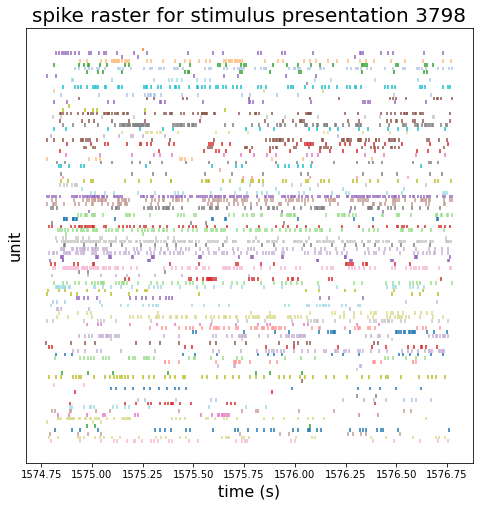

color                                                null
contrast                                              0.8
frame                                                null
orientation                                         315.0
phase                    [21211.93333333, 21211.93333333]
size                                       [250.0, 250.0]
spatial_frequency                                    0.04
start_time                                    1574.774823
stimulus_block                                        2.0
stimulus_name                           drifting_gratings
stop_time                                     1576.776513
temporal_frequency                                    4.0
x_position                                           null
y_position                                           null
duration                                          2.00169
stimulus_condition_id                                 246
Name: 3798, dtype: object

In [13]:
# first_drifting_grating_presentation_id = times['stimulus_presentation_id'].values[0]
## --> instead using our list:
first_drifting_grating_presentation_id = stim_pres_ids[0]
plot_times = times[times['stimulus_presentation_id'] == first_drifting_grating_presentation_id]

fig = raster_plot(plot_times, title=f'spike raster for stimulus presentation {first_drifting_grating_presentation_id}')
plt.show()

# also print out this presentation
session.stimulus_presentations.loc[first_drifting_grating_presentation_id]

### ... and we can look at the dataframe shown in this plot:

In [76]:
plot_times.head()

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
1574.776357,3798,950923011,0.001534
1574.776590,3798,950925626,0.001768
1574.776790,3798,950923880,0.001968
1574.777241,3798,950945986,0.002419
1574.777983,3798,950938657,0.003160


In [77]:
plot_times.tail()

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
1576.773123,3798,950938657,1.998300
1576.773956,3798,950936025,1.999133
1576.773958,3798,950925786,1.999135
1576.774872,3798,950954905,2.000050
1576.776042,3798,950948063,2.001219


In [78]:
# the number of spikes per unit
# --> 105 recording channels ("units" – not necessarily individual neurons), ranging in numbers of spikes
spikes_by_unit = plot_times.groupby(by='unit_id').agg('count')['stimulus_presentation_id']
print(spikes_by_unit)
print('The most active channel has '+str(max(spikes_by_unit))+' spikes')
print('The least active channel has '+str(min(spikes_by_unit))+' spike')

unit_id
950913517    27
950913567    32
950913684    12
950913850    34
950913877     3
             ..
950955053    32
950955974    51
950956527     3
950956778    33
950956870     1
Name: stimulus_presentation_id, Length: 105, dtype: int64
The most active channel has 153 spikes
The least active channel has 1 spike


### Checking the stimulus duration

***want to know if the duration given with the raster plot is the duration of the stimulus we're looking at, or if that's just referring to the time window of spikes that are associated with that stimulus***

In [79]:
loc_target_stim = session.stimulus_presentations.index == first_drifting_grating_presentation_id
print(session.stimulus_presentations[loc_target_stim]['duration'])

stimulus_presentation_id
3798    2.00169
Name: duration, dtype: float64


### *Important: the duration of the raster plot is the duration of the stimulus presentation – the spikes "tagged with" a given stimulus are the ones that occur during that stimulus*

## Can we easily get spikes from stretches of time with no active stimulus (not sure what the implications would of having samples from different time distances from the stimulus, but seems like we may want data without an active stimulus)

*First check*: Can we get the spike times of two subsequent stimuli, and select the spikes that are *not* associated with the first stimulus and are *before* the second?

In [80]:
# Want to get the start and end time that we'll use to bound our window of non-stimulus spikes:
# The start time will be the first time AFTER the stimulus is present, and the last time will
# be the last time BEFORE the next stimulus is present

# it looks like a lot of stimuli are presented back to back
# (i.e. from the head and tail it looks like the stop time of one is the start time of the next)
session.stimulus_presentations.tail()

,color,contrast,frame,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,x_position,y_position,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,,,,,
70383,null,0.8,null,60.0,0.75,"[250.0, 250.0]",0.04,9133.889309,14.0,static_gratings,9134.139517,null,null,null,0.250209,4886
70384,null,0.8,null,90.0,0.0,"[250.0, 250.0]",0.02,9134.139517,14.0,static_gratings,9134.389719,null,null,null,0.250201,4806
70385,null,0.8,null,60.0,0.0,"[250.0, 250.0]",0.08,9134.389719,14.0,static_gratings,9134.639920,null,null,null,0.250201,4874
70386,null,0.8,null,60.0,0.5,"[250.0, 250.0]",0.32,9134.639920,14.0,static_gratings,9134.890122,null,null,null,0.250201,4789
70387,null,0.8,null,60.0,0.0,"[250.0, 250.0]",0.16,9134.890122,14.0,static_gratings,9135.140323,null,null,null,0.250201,4809


In [82]:
# # checking the whole table to see if there's ever any time between stimuli

# # session.stimulus_presentations.iloc[0]['stop_time'] - session.stimulus_presentations.iloc[1]['start_time']

# for i in range(len(session.stimulus_presentations)-1):
#     inter_stim_time = session.stimulus_presentations.iloc[i]['stop_time'] - \
#                         session.stimulus_presentations.iloc[i+1]['start_time']
#     if inter_stim_time > 0.0:
#         print('Inter-stimulus time between stimuli ',str(i),' and ',str(i+1),' = ',str(inter_stim_time))

... no output; looks like there's no gap in listed times between stimuli. Going to check the documentation to see whether this time describes the constant presentation of a stimulus or if part of the duration is non-driven response.

*See Visual Stimuli section of the AllenSDK technical whitepaper (page 17/18) for full description of the experimental setup for all the stimuli, but it sounds like there truly isn't a gap between the visual stimuli.*

--------

In [83]:
session.units['probe_sampling_rate']

unit_id
950910352    29999.954846
950910364    29999.954846
950910371    29999.954846
950910392    29999.954846
950910435    29999.954846
                 ...     
950956911    30000.028033
950956870    30000.028033
950956845    30000.028033
950956952    30000.028033
950957053    30000.028033
Name: probe_sampling_rate, Length: 884, dtype: float64

## Create binary spike time series
***Need to put the spikes into binary (n_channels, n_samples) format in order to use this function***

In [14]:
# plan: create a matrix of zeros of shape [n_units, (end_time-start_time)/sampling_rate].
# Iterate through the spikes (rows of the times dataframe) and in the row corresponding to
# the spiking unit, place a 1 at the slot equal to the `time_since_stim...` value divided
# by the sampling rate. We'll first want to replace the unit_id with a sequential index
# so we can map unit_id directly to the row number in out spike matrix

## Function to take in session data and return binary spike matrix
## --> also take in plot_times because we need that as part of the process
def create_spike_matrix(session, plot_times):
    # 1) get the number of samples
    start = session.stimulus_presentations.loc[first_drifting_grating_presentation_id]['start_time']
    stop = session.stimulus_presentations.loc[first_drifting_grating_presentation_id]['stop_time']
    # find a way to go in and grab the sampling frequency automatically
    # from the session metadata
    sample_freq = 29999.954846 #<--- need to use exactly what's in the metadata

    # take the ceiling to make sure we get a whole number
    n_samples = int(np.ceil((stop-start)*sample_freq))

    # 2) initialize empty spike matrix
    n_units = len(plot_times['unit_id'].unique())
    spikes = np.zeros([n_units, n_samples])
    
    # 3) replace `unit_id` value with index
    unit_ids = plot_times['unit_id'].unique()

    id_to_index = {}

    for i in range(len(unit_ids)):
        id_to_index[unit_ids[i]] = i

    # creating a separate column to avoid issues with the original column
    # being overwritten
    plot_times['unit_id_indx'] = plot_times['unit_id'].apply(lambda x: id_to_index[x])
    
    # 4) Traverse through the rows adding spikes in the right place
    for row in plot_times.itertuples():
        # store the index that'll correspond to the target row in the spike mtx
        unit = row.unit_id_indx
        # find the sample this spike belongs in
        # --> want to round, not floor (what happens when you cast to int)
        sample = int(row.time_since_stimulus_presentation_onset*sample_freq)
        # flip the right value in the spike matrix
        spikes[unit][sample] = 1.0
        
    return spikes

In [16]:
spikes = create_spike_matrix(session, plot_times)

/opt/anaconda3/envs/allensdk/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [86]:
spikes.shape

(105, 60051)

***Writing a method to do the additional preprocessing step of binning the spike matrix down to 1 ms resolution:***

In [15]:
def bin_spike_matrix(spike_matrix):
    '''
    Function to perform the additional preprocessing step of binning our a given spike
    matrix down to 1 ms resolution. This is a common data processing step when dealing with
    neural spiking data. It'll reduce the sparsity of the data, but also the volume of data
    so this step will be used when training models on full sets of all trials for a given
    session/stimulus combination.
    '''
    num_samples = len(spike_matrix[0])
    # the data is sampled at 30 kHz so we divide by 30 to get down to 1 ms bins
    num_bins = num_samples // 30
    # initialize the array we'll populate with the binned samples from the original matrix
    binned_spikes = np.zeros((spike_matrix.shape[0], num_bins))
    # iterate through the columns of the original matrix constructing the binned columns
    for i in range(num_bins):
        binned_col = spike_matrix[:,i*30:min((i+1)*30, num_samples)].sum(axis=1)
        binned_spikes[:,i] = binned_col

    return binned_spikes

In [17]:
binned_spikes = bin_spike_matrix(spikes)

In [18]:
binned_spikes.shape

(105, 2001)

In [19]:
binned_spikes[:,1]

array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

*So it seems that there are 1ms bins that have multiple concurrent spikes in them - does this matter?*

In [116]:
# what the highest number of spikes we have in a single bin?
# ==> seven spikes in one bin seems like a lot...
concurrent_spikes = np.array([sum(binned_spikes[:,i]) for i in range(binned_spikes.shape[1])])
max(concurrent_spikes)

7.0

***Can put this in its own python file that takes in a session id and saves the spike matrix to file, but for now (until we know exactly what the parameters of that function should be) we'll just save our spike matrix here:***

In [35]:
# Adding a timestamp to the file name to prevent overwriting

from datetime import datetime
now = datetime.now()
dt_string = now.strftime("_%H_%M_%S")

with open('binary_spike_matrix_data/spike_mtx_'+str(session_id)+dt_string+'.npy', 'wb') as f:
    np.save(f, spikes)

In [14]:
# check the shape
spikes.shape

(105, 60051)

In [15]:
# check that we have the 0-indexed unit number
plot_times.head()

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset,unit_id_indx
spike_time,,,,
1574.776357,3798,950923011,0.001534,0
1574.776590,3798,950925626,0.001768,1
1574.776790,3798,950923880,0.001968,2
1574.777241,3798,950945986,0.002419,3
1574.777983,3798,950938657,0.003160,4


***Check our spike matrix by making a raster plot --> I'm actually not sure if we can do this practically, is there a different way to check the spikes matrix?***

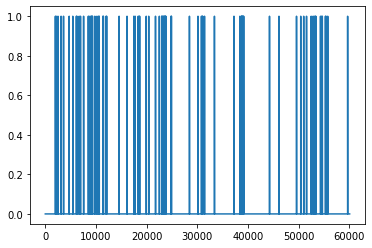

In [16]:
# nothing obviously wrong with the spacing or anything like that
plt.plot(spikes[50])

In [17]:
## ============================================================
## === Is there a good way to check the whole spike matrix? ===
## === It's too big to cast to a dataframe and I can't seem ===
## === To plot it using any of the standard methods         ===
## ============================================================

# spikes_df = pd.DataFrame(spikes)
## Create series of indexes containing positions for raster plot
# positions = spikes_df.apply(lambda x: spikes_df.index[x == 1])

# print(spikes_df)
# print(positions)

## Create raster plot with inverted y-axis to display columns in ascending order
# plt.eventplot(positions, lineoffsets=spikes_df.index, linelengths=0.75, colors='black')
# plt.yticks(range(positions.index.size), positions.index)
# plt.gca()

## Gaussian smoothing – getting the approximate rates

***Let's look a few recording channels to see what kind of kernel radius makes sense***

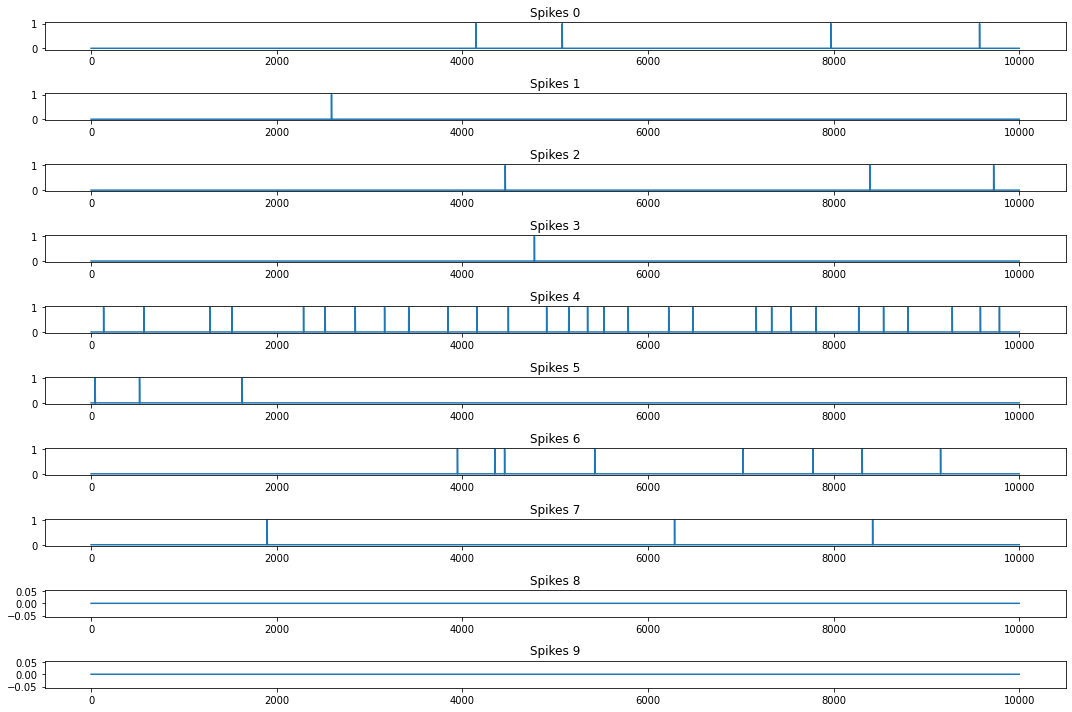

In [18]:
# plotting 10 units next to each other <- can
# use this to look at different clusters of units
# but all the channels should be in the same general ballpark
fig, axs = plt.subplots(10,figsize=(15,10))
for i in range(10):
    axs[i].plot(spikes[i][20000:30000])
    axs[i].set_title("Spikes "+str(i))
fig.tight_layout()
plt.show()

From this look, channel 4 shows us some stretches of reasonably close spiking. Does it make sense to make our kernel standard deviation the size of the gap between these "close" spikes? Reasoning: being $\sigma$ apart would give these stretches reasonably high rates, while allowing for higher rates in sections where the spikes are closer.

In [19]:
from scipy.ndimage import gaussian_filter1d

# function to take in a standard deviation and spikes ndarray
# and return the continuous "rates"

def create_rates(st_dev, spikes):
    # choice of sigma value -- in terms of time step
    # scaling by st_dev value to keep magnitude similar to original
    cts_spikes = st_dev*gaussian_filter1d(spikes,st_dev)
    return cts_spikes

filtered_spikes = create_rates(20, spikes)

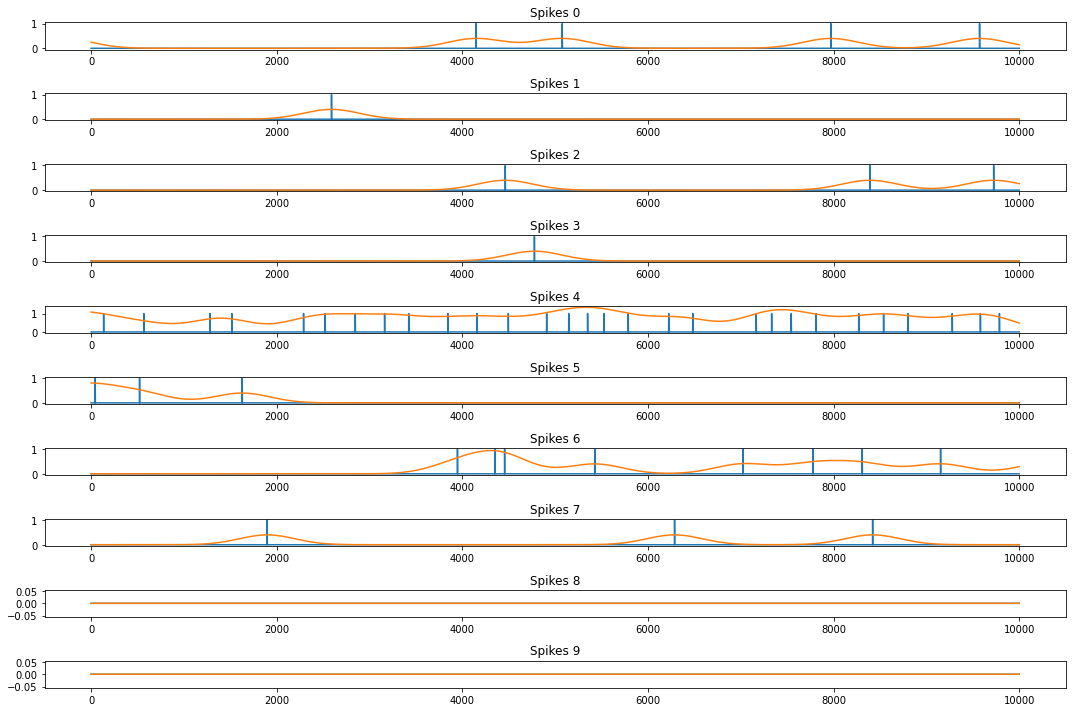

In [20]:
# looks reasonable?
fig, axs = plt.subplots(10,figsize=(15,10))
for i in range(10):
    axs[i].plot(spikes[i][20000:30000])
    axs[i].plot(filtered_spikes[i][20000:30000])
    axs[i].set_title("Spikes "+str(i))
fig.tight_layout()
plt.show()

## PCA

In [21]:
from sklearn.decomposition import PCA
# starting with 30 components to get an idea of the distribution of variance
ncomponents = 30
broad_pca = PCA(ncomponents)
broad_pca.fit(filtered_spikes.T)

PCA(n_components=30)

<StemContainer object of 3 artists>

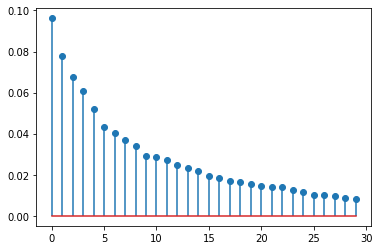

In [22]:
# Variance explained is dominated by the first eigenvalue
# (the stemplot represents the n largest eigenvalues 
# of the covariance matrix of the input signal)
plt.stem(broad_pca.explained_variance_ratio_)

In [23]:
broad_pca.components_.shape

(30, 105)

***Keeping the first 10 components:***

In [24]:
ncomponents = 10
pca = PCA(ncomponents)
pca.fit(filtered_spikes.T)
my_example_pca = pca.transform(filtered_spikes.T)
my_example_ipca = pca.inverse_transform(my_example_pca)

In [25]:
print(my_example_pca.shape)
print(my_example_ipca.shape)

(60051, 10)
(60051, 105)


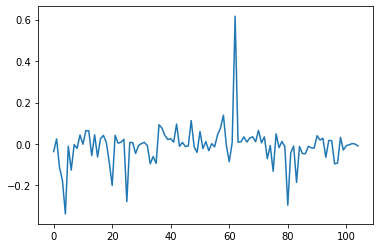

In [26]:
plt.plot(pca.components_[1])

In [27]:
# function to perform PCA with a specified number of
# components and calculate the R^2 and RMSE of the reconstruction
from sklearn.metrics import mean_squared_error

def plot_pca_smoothing(filtered_spikes, ncomponents, channel_number):
    pca = PCA(ncomponents)
    pca.fit(filtered_spikes.T)
    my_example_pca = pca.transform(filtered_spikes.T)
    my_example_ipca = pca.inverse_transform(my_example_pca)
    
    plt.figure(figsize=(10,7))
    plt.plot(filtered_spikes[channel_number].T, 'r')
    plt.plot(my_example_ipca[:,channel_number])
    plt.legend(('Smoothed spikes', 'PCA smoothed spikes'))
    # r^2 and rmse:
    _, _, c_tfilt, _, _ = scipy.stats.linregress(my_example_ipca[:,channel_number],filtered_spikes[channel_number].T)
    rms = mean_squared_error(my_example_ipca[:,channel_number],filtered_spikes[channel_number].T, squared=False)
    plt.title("PCA filtering  R^2=%.3f, rmse=%.3f" % (c_tfilt**2, rms));

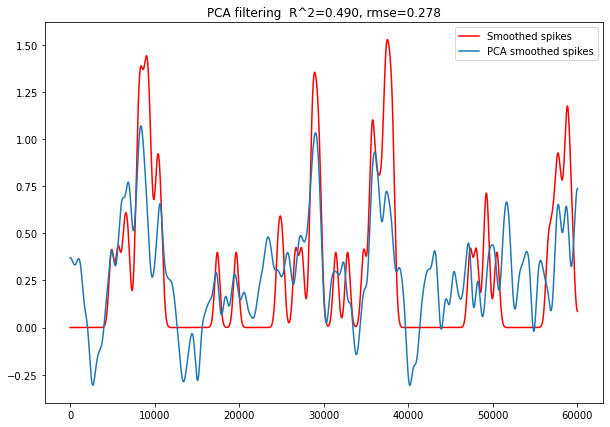

In [28]:
plot_pca_smoothing(filtered_spikes, 5, 80)

# New spike matrix method – need to correct for the variable channels present in each trial's data

***Summary of issue: across different trials (i.e. different presentations of a given stimulus within a given session) different numbers of units seem to be present***

***Summary of solution: for the session we're looking at, going to store a master list of unit_ids. For each trial spike matrix, going to determine the channel of a given spike by the index of the corresponding unit_id in the master list.***

In [20]:
# stim_pres_ids # <- list of different stimulus presentation ids for the drifting gradients
times.head() # <- the dataframe of spikes with time and associated unit and pres id

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
1574.776357,3798,950923011,0.001534
1574.776590,3798,950925626,0.001768
1574.776790,3798,950923880,0.001968
1574.777241,3798,950945986,0.002419
1574.777983,3798,950938657,0.003160


In [143]:
# ... and we select a single trial using our stim. pres. ids like this:
plot_times_example0 = times[times['stimulus_presentation_id'] == stim_pres_ids[0]]
# ... and we can look at the distinct number of units present like this:
print('The first stim. pres. has # distinct units = '+str(len(plot_times_example0['unit_id'].unique())))

plot_times_example60 = times[times['stimulus_presentation_id'] == stim_pres_ids[60]]
print('The sixty-first stim. pres. has # distinct units = '+str(len(plot_times_example60['unit_id'].unique())))

The first stim. pres. has # distinct units = 105
The sixty-first stim. pres. has # distinct units = 99


*Need to make a mapping based on the master list of unit_ids you get from the `times` dataframe (the df that comes from filtering out the low SNR units and selecting just the drifting gradient stimuli)*

***This mapping is something that we'll calculate when we first load in the data and we'll use it to replace the unit_id column in the times matrix with their integers that can be used as indices for the row in the spike matrices***

In [22]:
times.head()

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset
spike_time,,,
1574.776357,3798,950923011,0.001534
1574.776590,3798,950925626,0.001768
1574.776790,3798,950923880,0.001968
1574.777241,3798,950945986,0.002419
1574.777983,3798,950938657,0.003160


In [23]:
# 3) replace `unit_id` value with index
unit_ids = times['unit_id'].unique()

id_to_index = {}

for i in range(len(unit_ids)):
    id_to_index[unit_ids[i]] = i

# creating a separate column to avoid issues with the original column
# being overwritten
times['unit_id_indx'] = times['unit_id'].apply(lambda x: id_to_index[x])

In [24]:
times.head()

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset,unit_id_indx
spike_time,,,,
1574.776357,3798,950923011,0.001534,0
1574.776590,3798,950925626,0.001768,1
1574.776790,3798,950923880,0.001968,2
1574.777241,3798,950945986,0.002419,3
1574.777983,3798,950938657,0.003160,4


In [25]:
# now we'll select an example trial from our new times DF that has the unit index column
plot_times_example0 = times[times['stimulus_presentation_id'] == stim_pres_ids[0]]

In [26]:
plot_times_example0.tail()

,stimulus_presentation_id,unit_id,time_since_stimulus_presentation_onset,unit_id_indx
spike_time,,,,
1576.773123,3798,950938657,1.998300,4
1576.773956,3798,950936025,1.999133,77
1576.773958,3798,950925786,1.999135,30
1576.774872,3798,950954905,2.000050,75
1576.776042,3798,950948063,2.001219,78


In [27]:
def NEW_create_spike_matrix(session, plot_times, presentation_id, unit_masterlist):
    '''
    Function to process our dataframe of plot times and produce a binary matrix of spikes.
    In the session metadata we find that the electrodes measuring the different units in this session
    have different exact sampling frequencies (30 kHz +/- ~50 Hz). In order to make the transformation
    into binary spike matrix, we calculate the index of a spike based on its given 'time_since_stimulus_presentation_onset'
    using a hardcoded sampling frequency of 30000. Calculating these indices in this way effective resamples to
    30000 kHz exactly, and aligns the discrepantly sampled groups of units.
    
    We also pass in the unit_masterlist, which gives the mapping from all units in the session (with
    high SNR as we selected earlier) to index that we will use to determine which row to place a spike in
    in the matrix
    '''
    # 1) get the number of samples
    start = session.stimulus_presentations.loc[presentation_id]['start_time']
    print(start)
    stop = session.stimulus_presentations.loc[presentation_id]['stop_time']
    print(stop)
    # find a way to go in and grab the sampling frequency automatically
    # from the session metadata
    sample_freq = 30000

    # take the ceiling to make sure we get a whole number
    n_samples = int(np.ceil((stop-start)*sample_freq))

    # 2) initialize empty spike matrix
    ## ===> and in order to standardize the shape of the data across all trials we'll
    ## ===> use the number of units recorded in the session masterlist
    n_units = len(unit_masterlist)
    spikes = np.zeros([n_units, n_samples])
    
    # 4) Traverse through the rows adding spikes in the right place
    for row in plot_times.itertuples():
        # store the index that'll correspond to the target row in the spike mtx
        unit = row.unit_id_indx
        # find the sample this spike belongs in
        # --> want to round, not floor (what happens when you cast to int)
        sample = int(row.time_since_stimulus_presentation_onset*sample_freq)
        # flip the right value in the spike matrix
        spikes[unit][sample] = 1.0
        
    return spikes

In [28]:
plot_times_example = times[times['stimulus_presentation_id'] == stim_pres_ids[9]]

absolute_indx_spikes = NEW_create_spike_matrix(session, plot_times_example, 
                                               presentation_id=stim_pres_ids[9], 
                                               unit_masterlist=id_to_index)

1601.7974174972146
1603.7990974972147


In [29]:
absolute_indx_spikes.shape

(131, 60051)

In [30]:
len(id_to_index)

131

## Checking on the different sets of units present in each trial

In [31]:
times[times['stimulus_presentation_id'] == stim_pres_ids[0]]['unit_id_indx'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104])

In [32]:
# initialize a binary matrix that we'll populate with presence indicators of a unit in a given trial
unit_presence = np.zeros((len(id_to_index), len(stim_pres_ids)))
print(unit_presence.shape)

(131, 628)


In [33]:
for i in range(len(stim_pres_ids)):
    active_units = times[times['stimulus_presentation_id'] == stim_pres_ids[i]]['unit_id_indx'].unique()
    for u in active_units:
        unit_presence[u][i] = 1

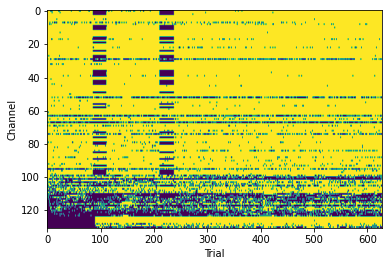

In [36]:
# plotting with savefig with high resolution, and axis labels
fig = plt.figure()
plt.imshow(unit_presence,aspect='auto')
plt.xlabel('Trial')
plt.ylabel('Channel')
plt.show()
fig.savefig('../../Summer/Data 2050/Practicum report/figures/trials_with_invalid_times.png', dpi=300)

*Could this be what the invalid times correspond to? Let's check whether trials 0-110, and 205-240 correspond invalid intervals*

***If a trial contains an part of an invalid interval we'll mark it with a red line in the heatmap***

In [37]:
session.invalid_times

,start_time,stop_time,tags
id,,,
0,1830.70,1910.47,"[EcephysProbe, 810755801, probeC]"
1,3196.68,3281.44,"[EcephysProbe, 810755801, probeC]"
2,4500.09,4578.29,"[EcephysProbe, 810755801, probeC]"
3,5589.68,5661.90,"[EcephysProbe, 810755801, probeC]"
4,6627.92,6854.53,"[EcephysProbe, 810755801, probeC]"
5,7829.74,7903.81,"[EcephysProbe, 810755801, probeC]"
6,8850.86,8937.06,"[EcephysProbe, 810755801, probeC]"
7,830.52,1846.17,"[EcephysProbe, 810755797, probeA]"


In [38]:
# creating a list that we'll fill with invalid intervals
invalid_intervals = []
for _, row in session.invalid_times.iterrows():
    invalid_intervals.append((row.start_time,row.stop_time))

In [39]:
invalid_intervals

[(1830.7, 1910.47),
 (3196.68, 3281.44),
 (4500.09, 4578.29),
 (5589.68, 5661.9),
 (6627.92, 6854.53),
 (7829.74, 7903.81),
 (8850.86, 8937.06),
 (830.52, 1846.17)]

In [40]:
# test of checking if a given trial has a spike time after a given threshold
(times[times['stimulus_presentation_id'] == stim_pres_ids[627]].index > 5380.0).any()

True

In [41]:
# a way we may want to check for multiple intervals
pd.Series([False, True, False]).any()

True

In [42]:
# a list of trials containing overlap with invalid intervals
corrupted_trials = []
for i in range(len(stim_pres_ids)):
    # get the list of spike times for a given trial
    trial_spikes = times[times['stimulus_presentation_id'] == stim_pres_ids[i]].index
    
    # then we loop through the invalid intervals and check if any of them are contained
    for time in trial_spikes:
        # have to go through by hand because we can't make two comparisons using an any() command
        for a,b in invalid_intervals:
            if time > a and time < b:
                # and if any of the intervals are contained then we'll add this trial to the corrupted list
                corrupted_trials.append(i)
                break
        break

In [43]:
corrupted_trials

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 222,
 223,
 224,
 225,
 226,
 227,
 228,
 229,
 230,
 231,
 232,
 233,
 234,
 235,
 236,
 237,
 238]

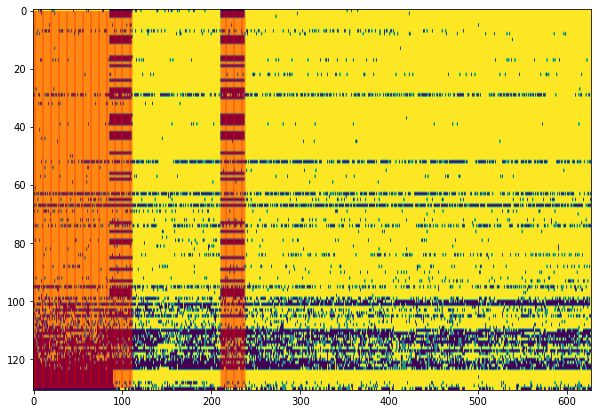

In [44]:
plt.figure(figsize=(10,7))
plt.imshow(unit_presence,aspect='auto')
plt.vlines(x=corrupted_trials,ymin=0,ymax=130,color='red', alpha=0.3)

***Okay that's perfect, so we just have to go through and rewrite our data acquisition method to throw out any trials with overlap with an invalid interval***

In [45]:
# let's try writing a version that doesn't mess around with the indices
# and just deals with the presentation ids straight away
corrupted_trials = []
for pres in stim_pres_ids:
    # get the list of spike times for a given trial
    trial_spikes = times[times['stimulus_presentation_id'] == pres].index
    
    # then we loop through the invalid intervals and check if any of them are contained
    for time in trial_spikes:
        # have to go through by hand because we can't make two comparisons using an any() command
        for a,b in invalid_intervals:
            if time > a and time < b:
                # and if any of the intervals are contained then we'll add this trial to the corrupted list
                corrupted_trials.append(pres)
                break
        break

In [46]:
stim_pres_ids_cleaned = np.array([pres for pres in stim_pres_ids if pres not in corrupted_trials])

In [47]:
len(stim_pres_ids_cleaned)

488

In [48]:
# initialize a binary matrix that we'll populate with presence indicators of a unit in a given trial
unit_presence_cleaned = np.zeros((len(id_to_index), len(stim_pres_ids_cleaned)))
print(unit_presence_cleaned.shape)

for i in range(len(stim_pres_ids_cleaned)):
    active_units = times[times['stimulus_presentation_id'] == stim_pres_ids_cleaned[i]]['unit_id_indx'].unique()
    for u in active_units:
        unit_presence_cleaned[u][i] = 1

(131, 488)


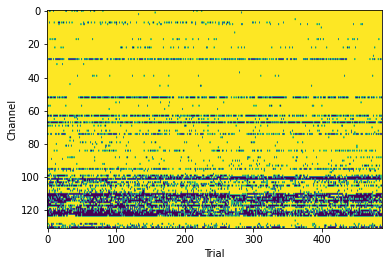

In [50]:
fig = plt.figure()
plt.imshow(unit_presence_cleaned,aspect='auto')
plt.xlabel('Trial')
plt.ylabel('Channel')
plt.show()
fig.savefig('../../Summer/Data 2050/Practicum report/figures/trials_without_invalid_times.png', dpi=300)